<a href="https://colab.research.google.com/github/dani0047/driver_activity_recognition/blob/main/DAR_IC_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import all necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as Model
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from tqdm import tqdm
import csv
from PIL import Image
from torch.utils.data import Dataset

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [ ]:
#Select GPU as device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda
Tesla V100-SXM2-16GB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_name = 'state_farm_kaggle'
folder_path = os.path.join('/content', folder_name)

os.makedirs(folder_path, exist_ok = True)

In [ ]:
drive_csv_path = '/content/drive/MyDrive/State Farm Kaggle Dataset/driver_imgs_list.csv'

colab_csv_path = '/content/state_farm_kaggle/driver_imgs_list.csv'

shutil.copy(drive_csv_path, colab_csv_path)

'/content/state_farm_kaggle/driver_imgs_list.csv'

In [ ]:
# shutil.rmtree('/content/state_farm_kaggle')

In [ ]:
import zipfile

file_dir = '/content/state_farm_kaggle'
target_folder = 'train'

#Upload train data folder to google colab files directory
if not os.path.exists(os.path.join (file_dir, target_folder)):
  zip_train= zipfile.ZipFile('/content/drive/MyDrive/State Farm Kaggle Dataset/train.zip', 'r') #Open train zip file in read mode
  zip_train.extractall(file_dir) #Store file to google colab
  zip_train.close()

In [ ]:
df = pd.read_csv('/content/state_farm_kaggle/driver_imgs_list.csv')
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [ ]:
df.shape

(22424, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB


In [ ]:
class_dict = {0 : "safe driving",
              1 : "texting - right",
              2 : "talking on the phone - right",
              3 : "texting - left",
              4 : "talking on the phone - left",
              5 : "operating the radio",
              6 : "drinking",
              7 : "reaching behind",
              8 : "hair and makeup",
              9 : "talking to passenger"}

In [ ]:
path_train = os.path.join(file_dir,'train')
classes = [c for c in os.listdir(path_train) if not c.startswith(".")]
classes.sort()
num_classes = len(classes)
print(classes)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


Total number of training data : 22424


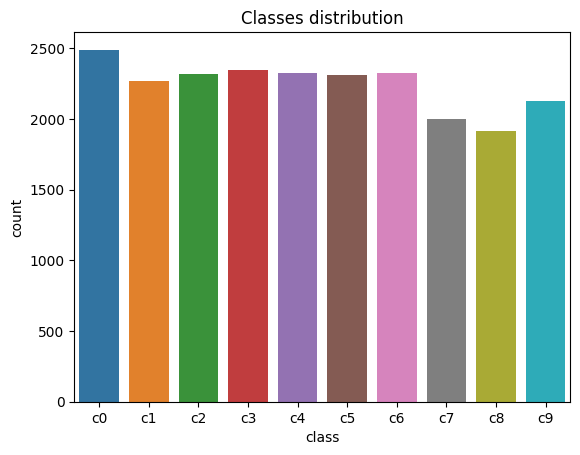

In [ ]:
d = {"img" : [], "class" : []}
for c in classes:
    imgs = [img for img in os.listdir(os.path.join(path_train,c)) if not img.startswith(".")]
    for img in imgs:
        d["img"].append(img)
        d["class"].append(c)
df = pd.DataFrame(d)
ax = sb.countplot(data=df,x="class")
ax.set(title="Classes distribution")
print("Total number of training data :",len(df))

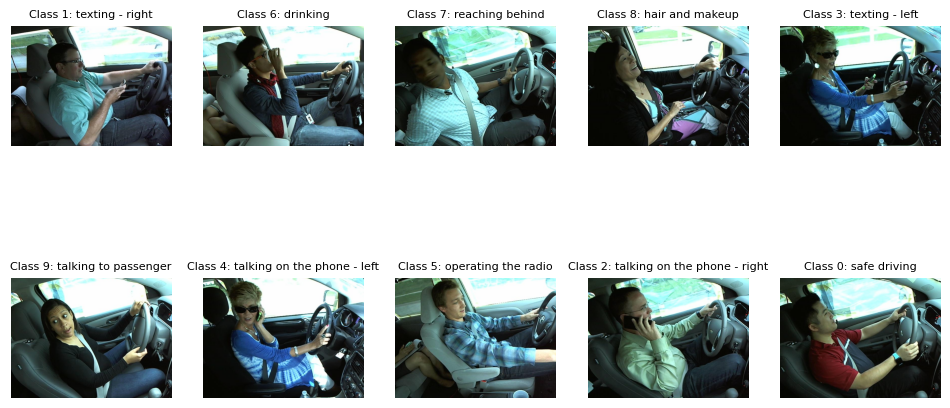

In [ ]:
torch.manual_seed(42)
fig, axs = plt.subplots(2, 5, figsize=(12, 6))

for i, class_name in enumerate(os.listdir(path_train)):
  classes.append(class_name)
  class_idx = int(list(class_name)[1])
  class_path = os.path.join(path_train, class_name)
  images = [img for img in os.listdir(class_path)]
  random_index = np.random.randint(len(images))
  image_path = os.path.join(class_path, images[random_index])
  image = mpimg.imread(image_path)


  row = i // 5  # Determine the row in the grid
  col = i % 5   # Determine the column in the grid
  ax = axs[row, col]  # Select the current subplot
  ax.imshow(image)
  ax.axis('off')
  ax.set_title(f'Class {class_idx}: {class_dict[class_idx]}', fontdict={'fontsize': 8, 'fontweight': 'medium'})


In [ ]:
torch.manual_seed(42)
data = datasets.ImageFolder(root = path_train)

valid_size = int(0.2*len(data))
train_size = len(data)-valid_size

train_data, valid_data = random_split(data, [train_size, valid_size])

In [ ]:
# print(f'Found {len(train_data)} images that belong to {len(train_data.classes)} classes in train dataset ')
# print(f'Found {len(valid_data)} images that belong to {len(valid_data.classes)} classes in validation dataset')

In [ ]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
image_size = (244,244)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std)
    ])
}

In [ ]:
train_data.dataset.transform = data_transforms['train']
valid_data.dataset.transform = data_transforms['valid']

In [ ]:
batch_size = 16

#Create a data loader with batches
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([16, 3, 244, 244]), torch.Size([16]))

#Build Model

Load Pretrained Model from TorchVision

Add Extra Dense Layer for Classification

In [ ]:
pretrained_model = None

if pretrained_model == None:
  model = Model.resnet50(weights='DEFAULT')

for param in model.parameters():
    param.requires_grad = False  # Freeze pre-trained layers




In [ ]:
summary(model=model,
        input_size=(batch_size, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [16, 3, 224, 224]    [16, 1000]           --                   False
├─Conv2d (conv1)                         [16, 3, 224, 224]    [16, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [16, 64, 112, 112]   [16, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [16, 64, 112, 112]   [16, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [16, 64, 112, 112]   [16, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [16, 64, 56, 56]     [16, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [16, 64, 56, 56]     [16, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [16, 64, 56, 56]     [16, 64, 56, 56]     (4,096)              False
│    │    └─

In [ ]:
#Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = num_classes
num_features = model.fc.in_features

# Recreate the classifier layer and seed it to the target device
model.fc= nn.Sequential(
    nn.Linear(num_features, output_shape)
).to(device)


In [ ]:
summary(model=model,
        input_size=(batch_size, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [16, 3, 224, 224]    [16, 10]             --                   Partial
├─Conv2d (conv1)                         [16, 3, 224, 224]    [16, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [16, 64, 112, 112]   [16, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [16, 64, 112, 112]   [16, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [16, 64, 112, 112]   [16, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [16, 64, 56, 56]     [16, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [16, 64, 56, 56]     [16, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [16, 64, 56, 56]     [16, 64, 56, 56]     (4,096)              False
│    │    

In [ ]:
criterion= nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, threshold = 2)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_accuracy):
        if self.best_score is None:
            self.best_score = val_accuracy
        elif val_accuracy < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_accuracy
            self.counter = 0

In [ ]:
early_stopping = EarlyStopping(patience=3, min_delta=0.01)

In [ ]:
class CSVLogger:
    def __init__(self, filename, fieldnames=['epoch','learning_rate', 'epoch_duration', 'train_loss', 'train_acc', 'valid_acc']):
        self.filename = filename
        self.fieldnames = fieldnames

        # Create file and write header
        with open(self.filename, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=self.fieldnames)
            writer.writeheader()

    def log(self, epoch, lr, epoch_duration, train_loss, train_acc, valid_acc):
        with open(self.filename, 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=self.fieldnames)
            writer.writerow({
                'epoch': epoch,
                'learning_rate': lr,
                'epoch_duration': epoch_duration,
                'train_loss': train_loss,
                'train_acc': train_acc,
                'valid_acc': valid_acc
            })

In [ ]:
log_path = '/content/drive/MyDrive/State Farm Kaggle Dataset/training_log/resnet50'

In [ ]:
logger = CSVLogger(os.path.join(log_path,'training_log.csv'))

In [ ]:
cp_filename = os.path.join(log_path,'my_checkpoint.pth.tar')

def save_checkpoint(state, filename=cp_filename):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
def train_model(model, criterion, optimizer, scheduler, epochs = 5):
    losses = []
    train_accuracies = []
    valid_accuracies = []
    best_acc = 0

    for epoch in tqdm(range(epochs)):
      since = time.time()
      print(f"\nEpoch: {epoch}\n-------")
      #------- Training----------
      train_loss, train_acc = 0, 0
      model.train()
      for batch, (X_train, y_train) in enumerate(train_loader):
        model.train()
        # 1. Forward pass
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        optimizer.zero_grad()  # Reset gradients at the start of each epoch


        train_pred = model(X_train)
        # 3. Calculate loss
        loss = criterion(train_pred, y_train)
        train_loss += loss

        # 4. Calculate accuracy (preds need to be same as y_true)
        train_acc += accuracy_fn(y_true=y_train, y_pred=train_pred.argmax(dim=1))

        # 5. Loss backward
        loss.backward()

        # 6. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 100 == 0:
          print(f"Looked at {batch * len(X_train)}/{len(train_loader.dataset)} samples")

      # Divide total train loss by length of train dataloader (average loss per batch per epoch)
      train_loss /= len(train_loader)

      # Divide total accuracy by length of test dataloader (per batch)
      train_acc /= len(train_loader)

      epoch_duration = time.time()-since
      losses.append(train_loss)
      train_accuracies.append(train_acc)

      ### Testing
      # Setup variables for accumulatively adding up loss and accuracy
      valid_acc = 0
      model.eval()
      with torch.inference_mode():
        for X_valid, y_valid in valid_loader:
          # 1. Forward pass
          X_valid = X_valid.to(device)
          y_valid = y_valid.to(device)
          valid_pred = model(X_valid)

          # 3. Calculate accuracy (preds need to be same as y_true)
          valid_acc += accuracy_fn(y_true=y_valid, y_pred=valid_pred.argmax(dim=1))

        # Calculations on test metrics need to happen inside torch.inference_mode()

        # Divide total accuracy by length of test dataloader (per batch)
        valid_acc /= len(valid_loader)
        valid_accuracies.append(valid_acc)

      # Model Checkpointing
      if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint({'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()})

      for param_group in optimizer.param_groups:
        lr = param_group['lr']
        print(lr)

      scheduler.step(valid_acc)

      ## Print out what's happening
      print(f"\nEpoch duration: {epoch_duration:.0f}s, lr: {lr}, Train loss: {train_loss:.5f}, Train acc: {train_acc:.2f}% | Valid acc: {valid_acc:.2f}%\n")

      logger.log(epoch, lr, epoch_duration, train_loss, train_acc, valid_acc)


      early_stopping(valid_acc)
      if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    print("Finished Training")
    return model, losses, train_accuracies, valid_accuracies



In [ ]:
model, training_losses, training_accs, valid_accs = train_model(model, criterion, optimizer, lrscheduler, epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]


Epoch: 0
-------
Looked at 0/17940 samples
Looked at 1600/17940 samples
Looked at 3200/17940 samples
Looked at 4800/17940 samples
Looked at 6400/17940 samples
Looked at 8000/17940 samples
Looked at 9600/17940 samples
Looked at 11200/17940 samples
Looked at 12800/17940 samples
Looked at 14400/17940 samples
Looked at 16000/17940 samples
Looked at 17600/17940 samples
=> Saving checkpoint
0.01

Epoch duration: 52s, lr: 0.01, Train loss: 0.95065, Train acc: 79.04% | Valid acc: 92.75%



  3%|▎         | 1/30 [01:05<31:39, 65.49s/it]


Epoch: 1
-------
Looked at 0/17940 samples
Looked at 1600/17940 samples
Looked at 3200/17940 samples
Looked at 4800/17940 samples
Looked at 6400/17940 samples
Looked at 8000/17940 samples
Looked at 9600/17940 samples
Looked at 11200/17940 samples
Looked at 12800/17940 samples
Looked at 14400/17940 samples
Looked at 16000/17940 samples
Looked at 17600/17940 samples
=> Saving checkpoint


  7%|▋         | 2/30 [02:10<30:21, 65.06s/it]

0.01

Epoch duration: 51s, lr: 0.01, Train loss: 0.38697, Train acc: 93.78% | Valid acc: 94.44%


Epoch: 2
-------
Looked at 0/17940 samples
Looked at 1600/17940 samples
Looked at 3200/17940 samples
Looked at 4800/17940 samples
Looked at 6400/17940 samples
Looked at 8000/17940 samples
Looked at 9600/17940 samples
Looked at 11200/17940 samples
Looked at 12800/17940 samples
Looked at 14400/17940 samples
Looked at 16000/17940 samples
Looked at 17600/17940 samples
=> Saving checkpoint


 10%|█         | 3/30 [03:15<29:16, 65.05s/it]

0.01

Epoch duration: 52s, lr: 0.01, Train loss: 0.27528, Train acc: 95.80% | Valid acc: 96.15%


Epoch: 3
-------
Looked at 0/17940 samples
Looked at 1600/17940 samples
Looked at 3200/17940 samples
Looked at 4800/17940 samples
Looked at 6400/17940 samples
Looked at 8000/17940 samples
Looked at 9600/17940 samples
Looked at 11200/17940 samples
Looked at 12800/17940 samples
Looked at 14400/17940 samples
Looked at 16000/17940 samples
Looked at 17600/17940 samples
=> Saving checkpoint


 13%|█▎        | 4/30 [04:20<28:15, 65.20s/it]

0.01

Epoch duration: 52s, lr: 0.01, Train loss: 0.21892, Train acc: 96.54% | Valid acc: 96.77%


Epoch: 4
-------
Looked at 0/17940 samples
Looked at 1600/17940 samples
Looked at 3200/17940 samples
Looked at 4800/17940 samples
Looked at 6400/17940 samples
Looked at 8000/17940 samples
Looked at 9600/17940 samples
Looked at 11200/17940 samples
Looked at 12800/17940 samples
Looked at 14400/17940 samples
Looked at 16000/17940 samples
Looked at 17600/17940 samples


 17%|█▋        | 5/30 [05:25<27:01, 64.88s/it]

0.001

Epoch duration: 51s, lr: 0.001, Train loss: 0.19040, Train acc: 97.26% | Valid acc: 96.55%


Epoch: 5
-------
Looked at 0/17940 samples
Looked at 1600/17940 samples
Looked at 3200/17940 samples
Looked at 4800/17940 samples
Looked at 6400/17940 samples
Looked at 8000/17940 samples
Looked at 9600/17940 samples
Looked at 11200/17940 samples
Looked at 12800/17940 samples
Looked at 14400/17940 samples
Looked at 16000/17940 samples
Looked at 17600/17940 samples


 20%|██        | 6/30 [06:29<25:52, 64.69s/it]

0.001

Epoch duration: 51s, lr: 0.001, Train loss: 0.18488, Train acc: 97.28% | Valid acc: 96.46%


Epoch: 6
-------
Looked at 0/17940 samples
Looked at 1600/17940 samples
Looked at 3200/17940 samples
Looked at 4800/17940 samples
Looked at 6400/17940 samples
Looked at 8000/17940 samples
Looked at 9600/17940 samples
Looked at 11200/17940 samples
Looked at 12800/17940 samples
Looked at 14400/17940 samples
Looked at 16000/17940 samples
Looked at 17600/17940 samples


 20%|██        | 6/30 [07:33<30:13, 75.57s/it]

0.001

Epoch duration: 51s, lr: 0.001, Train loss: 0.18146, Train acc: 97.38% | Valid acc: 96.75%

Early stopping triggered
Finished Training


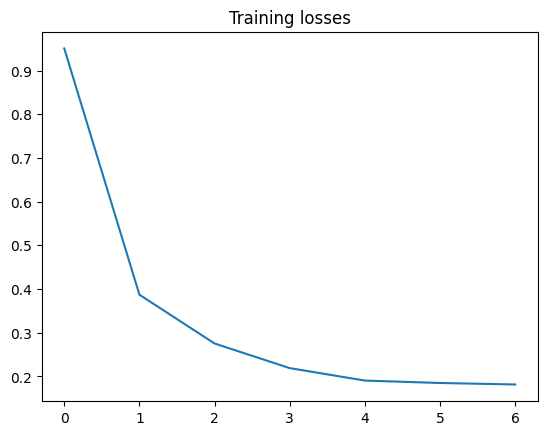

In [ ]:
training_losses_cpu = [loss.detach().cpu().numpy() for loss in training_losses]
plt.title('Training losses')
plt.plot(training_losses_cpu)
plt.show()

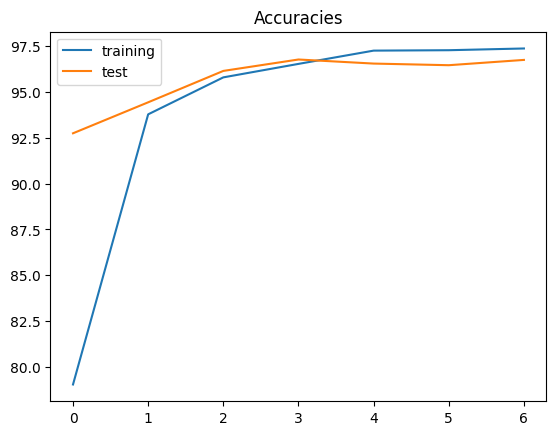

In [ ]:
plt.title('Accuracies')
plt.plot(training_accs, label = 'training')
plt.plot(valid_accs, label = 'test')
plt.legend()
plt.show()

#Testing the model


In [ ]:
#Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = None

model = Model.resnet50(weights='DEFAULT')
num_feature = model.fc.in_features
model.fc= nn.Sequential(
    nn.Linear(num_features, output_shape)
).to(device)


In [ ]:
checkpoint_path = os.path.join(log_path, 'my_checkpoint.pth.tar')

if torch.cuda.is_available():
    checkpoint = torch.load(checkpoint_path)
else:
    # For loading on CPU when trained on GPU
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Load the model state
model.load_state_dict(checkpoint['state_dict'])

# Move the model to the device
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
summary(model=model,
        input_size=(batch_size, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [16, 3, 224, 224]    [16, 10]             --                   True
├─Conv2d (conv1)                         [16, 3, 224, 224]    [16, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [16, 64, 112, 112]   [16, 64, 112, 112]   128                  True
├─ReLU (relu)                            [16, 64, 112, 112]   [16, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [16, 64, 112, 112]   [16, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [16, 64, 56, 56]     [16, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [16, 64, 56, 56]     [16, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [16, 64, 56, 56]     [16, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [ ]:
# shutil.rmtree('/content/state_farm_kaggle/test')

In [ ]:
file_dir = '/content/state_farm_kaggle'
target_folder = 'test'

#Upload train data folder to google colab files directory
if not os.path.exists(os.path.join (file_dir, target_folder)):
  zip_train= zipfile.ZipFile('/content/drive/MyDrive/State Farm Kaggle Dataset/test.zip', 'r') #Open train zip file in read mode
  zip_train.extractall(file_dir) #Store file to google colab
  zip_train.close()

In [ ]:
transform_test = transforms.Compose([transforms.Resize((image_size)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(norm_mean, norm_std)
                                    ])

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Convert to RGB for consistency

        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
path_test = os.path.join(file_dir, 'test')
test_image_paths = [os.path.join(path_test, img) for img in os.listdir(path_test) if not img.startswith(".")]
test_image_paths.sort()  # Sorting the file names if necessary

In [ ]:
test_dataset = CustomImageDataset(image_paths=test_image_paths, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
total_images = len(test_loader.dataset)
print(f"Total number of images in the dataset: {total_images}")

Total number of images in the dataset: 79726


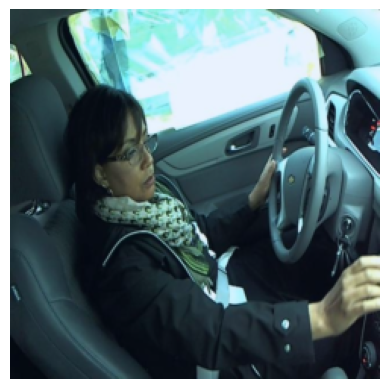

In [ ]:
images= next(iter(test_loader))

image = images[0]

# Convert the image tensor to a numpy array
# If the image has been normalized or has more than 3 channels, additional processing may be needed
image = image.numpy().transpose((1, 2, 0))

# Normalize the pixel values to [0, 1] for display
image = (image - image.min()) / (image.max() - image.min())

# Plot the image
plt.imshow(image)
plt.axis('off')  # Turn off axis numbers and labels
plt.show()

Total inference time for the entire dataset is 530.9900 seconds


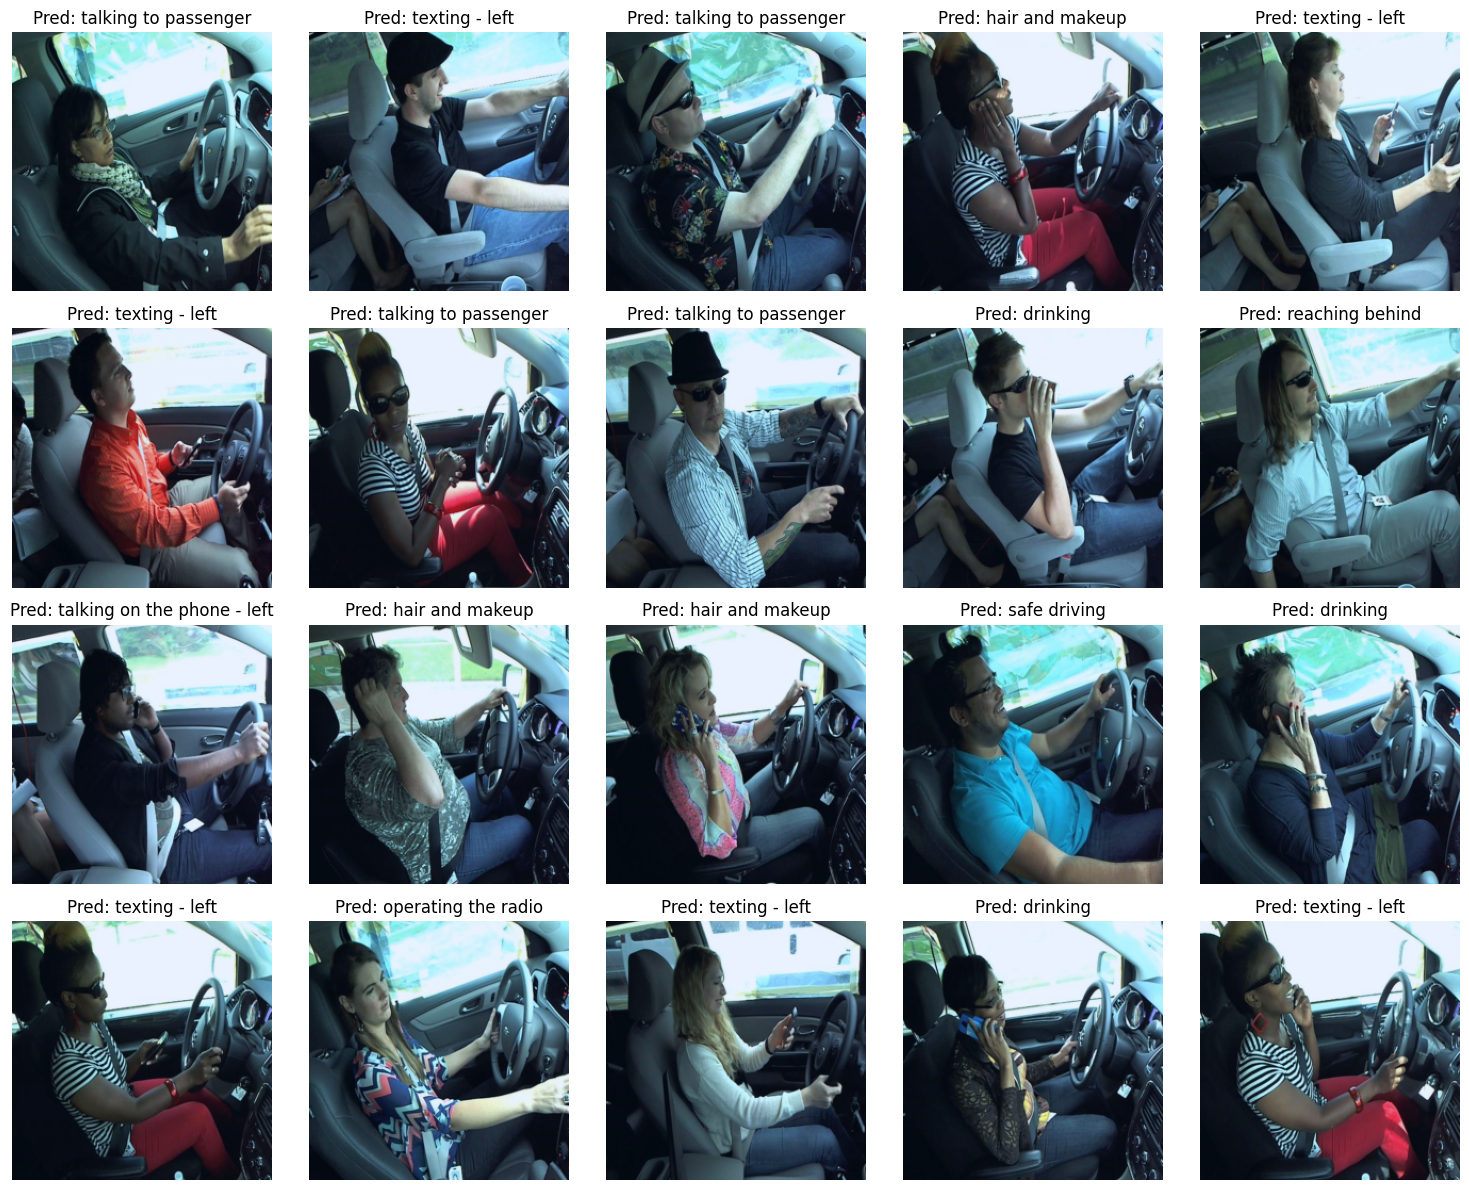

In [ ]:
# Parameters for visualization
num_images_to_display = 20
images_per_row = 5
num_rows = 4
images_displayed = 0

# Prepare the figure for visualization
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 12))
axes = axes.flatten()

# Start the timer
start_time = time.time()

# Prediction phase
all_preds = []
images_to_display = []
with torch.no_grad():
    for X_test in test_loader:
        X_test = X_test.to(device)
        test_pred = model(X_test)
        preds = test_pred.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)

        # Store images for visualization
        if len(images_to_display) < num_images_to_display:
            images_to_display.extend(X_test.cpu().numpy())

# Stop the timer
total_time = time.time() - start_time
print(f"Total inference time for the entire dataset is {total_time:.4f} seconds")

# Visualization of the first 20 images
for i in range(num_images_to_display):
    image = images_to_display[i].transpose((1, 2, 0))
    image = (image - image.min()) / (image.max() - image.min())  # Normalize
    ax = axes[i]
    ax.imshow(image)
    ax.set_title(f"Pred: {class_dict[all_preds[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()